In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)


# Machine learning
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Statistcs
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Figures
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [3]:
#All the functions. I am gonna use!

def draw_histograms(df, variables, n_rows, n_cols):
    fig, axes =plt.subplots(n_rows, n_cols, figsize = (12,8))
    for i, var_name in enumerate(variables):
        ax = axes[i//n_cols, i%n_cols]
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    plt.show()
    
def box_tidewell_test(dataset, continuous_variable):
    for variable in continuous_variable:
        dataset[f'{variable}:Log_{variable}'] = dataset[variable].apply(lambda x: x * np.log(x)) 
    columns = continuous_variable + dataset.columns.tolist()[-len(continous_var):]
    X = df_copy[columns]
    y = df_copy['target']
    X_constant = sm.add_constant(X, prepend=False)
    results = GLM(y, X_constant, family=families.Binomial()).fit()
    print(results.summary())
    
def correlation_matrix(dataset):
    corrMatrix = df.corr()
    plt.subplots(figsize=(10, 6))
    sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
    plt.show()
    
def residuals(X, y):
    model = GLM(y, X, family=families.Binomial())
    results = model.fit()
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, title="Residual Series Plot",
                        xlabel="Index Number", ylabel="Deviance Residuals")
    ax.plot(X.index.tolist(), stats.zscore(results.resid_deviance))
    plt.axhline(y=0, ls="--", color='red');
    

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Summary</h1>
</div>

<p style = "font-size: 20px; text-align:center;">This dataset ca be used to predict the presence of kidney stones based on urine analysis. The data is obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics. ---> Evaluation with ROC-cruve</p>


Source:https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Data Exploring</h1>
</div>

In [4]:
#Import the traindataset.
df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv') 
#Import the testdataset.
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
#Import the submissionfiles.
submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
#Explore the five first rows in the traindataset.
df.head() 

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
#Let's see what the shape is.
df.shape 
#414 rows and 8 columns.

(414, 8)

In [6]:
#Check the datatypes in dataframe.
df.dtypes 

id           int64
gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
target       int64
dtype: object

In [7]:
#Check the dataframe summary.
df.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


<p style = "font-size: 18px; text-align:center;">Let's look at each columns what it all does (Dataset description):</p>

- Gravity (the density of the urine relative to water). It's a measure of how much stuff is in your pee. The more stuff there is, the higher the gravity. This stuff can include things like salt, sugar, and water products that your body is getting rid of. Measuring gravity in urine is important because it can tell doctors if your kedneys are working properly and if you're drinking enough water. High gravity means dehydratend or kidney problems. Low gravity means you're drinking too much water or have other health problems. ---> Continuous Feature

- ph (the negative logarithm of the hydrogen ion). It's a measure of how acidic or basic something is. A low ph level in urine can indicate the persence of certain types of kidney stones, while a high ph level can indicate a urinary tract infection or other health problems. ---> Continuous Feature

- Osmo (Osmolarity, a unit used in biology and medicine but not in physical chemistery. Osmolarity is proportional to the concentraion of molecules in solution). It hels doctors to understand how well your kidney working. If osmolarity is high, it could mean that your kidneys are not effectively filtering out excess particles, which can be a sign of kidney disease. Low urine osmolarity could be a sign of overhydration or certain hormonal imbalances. ---> Continuous Feature

- Cond (Conductivity is proportional to the concentration of charged ions in solution). Conductivity in urine can be useful in diagnosing certain health conditions, such as electrolyte imbalances, kidney disease, and metabolic disorders. it helps doctors determine the concentration of ions, such as odium, chloride and potssium, in the urine. These ions are important the maintaining the body's electrolyte balance, which is essential for normal body function. ---> Continuous Feature

- Urea (Urea concentration in millimoles per litre). It's a waste product produced by the liver. Urea is carried in the bloodstream to the kidneys, which filter it out and eliminate it from the body through urine. it's provide information about kidney function, as well as liver function. ---> Continuous Feature

- Calc (Calcium concentration in millimolesllitre). The amount of calcium can provide information about the body's calcium balance. The kidneys play a crucial role in regulating calcium levels in the body by either excreting excess calcium into the urine or reabsorbing it back into the bloodstream. ---> Continuous Feature

- Target: 0 - absence of stone and 1 - presence of stone.

source: https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis


<p style = "font-size: 18px; text-align:center;">Futher I am gonna drop the Id. It have no function here now!</p>


In [8]:
#Remove the id column.
df = df.drop('id', axis = 1) 

#Remove the cost column (it's now only have the predictor variable).
test = test.drop('id', axis = 1) 

#Select the id!
submission_id = submission['id'] 


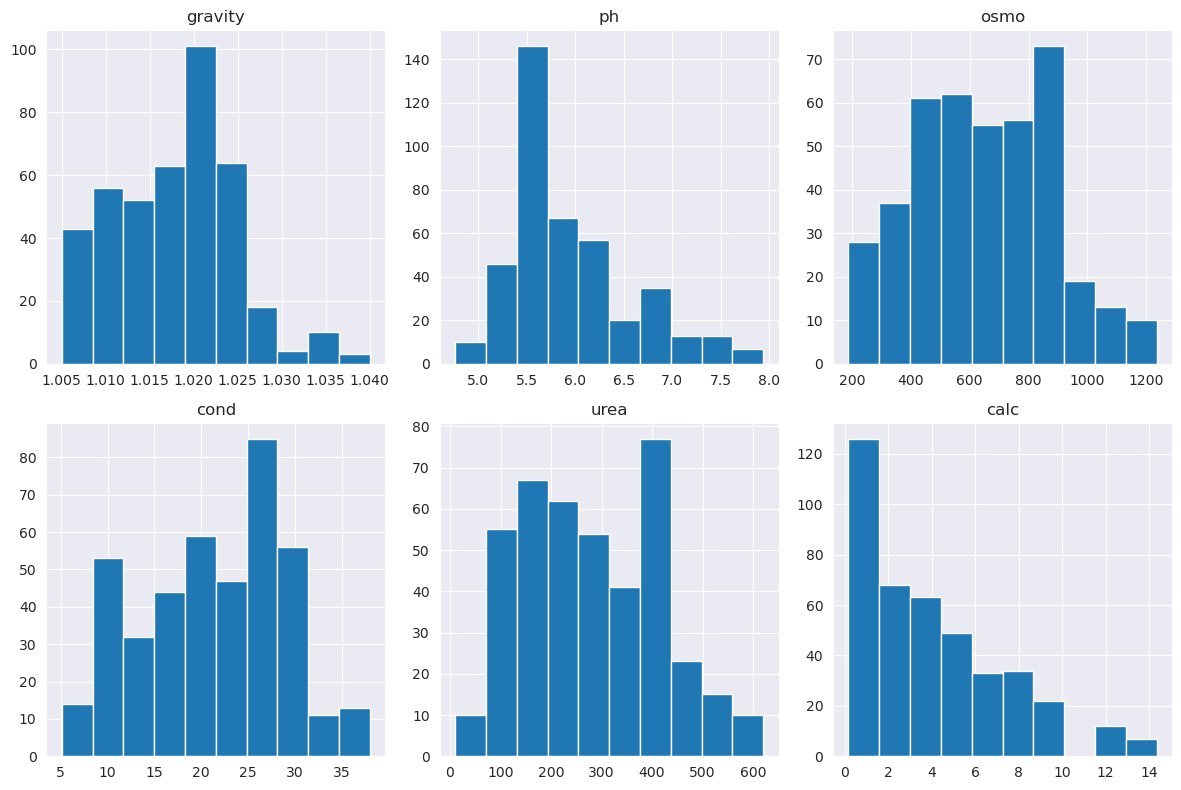

In [9]:
#Select only the relevance columns.
Input_columns = ["gravity","ph", "osmo", "cond", "urea", "calc"]
#Make a beautiful histogram for each columns in the train_dataset.
draw_histograms(df ,df[Input_columns], 2, 3)

<p style = "font-size: 18px; text-align:center;">From this we can conclude that all the input features are not normally distributed.</p>

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

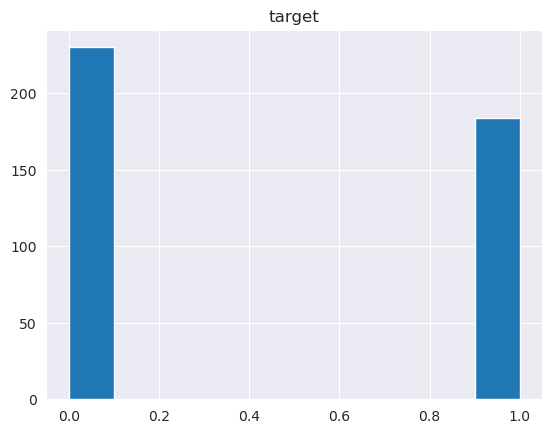

In [10]:
#Let also see the histogram from the output data.
df.hist('target')

<p style = "font-size: 16px; text-align:center;">From this we can conclude that the output features have balanced classes. There is also no missing values in the columns!</p>

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Machine Learning</h1>
</div>

<p style = "font-size: 16px; text-align:center;">This time our output feature are binary classification. You have or you don't have kidney stone! Binary classification is a type of supervised machine learning task where the goal is to predict whether a given input belongs to one of two possible classes. For this we gonna watch which algorithm the best is. The most popular are:</p>

- Logistic Regression
- Decision Trees
- Random Forests
- Support Vector Machines
- Naive Bayes
- K-Nearest Neigbors
- Neural Networks
- Gradient Boosting Algorithms
- AdaBoost
- Ensemble Methods
- Etcetera...

<p style = "font-size: 16px; text-align:center;">Each of these algorithms has it own advantages and disadvangtages, and the choice of algorithm will depend on the specific charachteristics of the data, the trainingtime, the size of the dataset and the required level of intpretability. It's common to try multiple algorithms and compare their performance on a validation set! But for this playground we gonna use Logistic Regression, Decision Tree and Random Forest.</p>

<p style = "font-size: 25px; text-align:left;">Logisitc Regression</p>
<p style = "font-size: 16px; text-align:left;">Logisitc Regression has several advantages (simplicity, interpretability, and ability to handle nonlinear relationships between the input and the output feature). ---> But, it may not perform as well as more complex algorithms on highly nonlinear datasets. See more on the source: </p>


source: https://www.ibm.com/topics/logistic-regression, https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/

<p style = "font-size: 25px; text-align:left;">Decision Tree</p>
<p style = "font-size: 16px; text-align:left;">Decision Tree has several advantages (simplicity, interpretability, and ability to handle nonlinear relationships between the input and the output feature). ---> But, decision trees can be to overfit if the tree is too deep. See more on the source: </p>

source: https://www.ibm.com/topics/decision-trees?mhsrc=ibmsearch_a&mhq=decision%20tree, https://www.educba.com/decision-tree-advantages-and-disadvantages/

<p style = "font-size: 25px; text-align:left;">Random Forest</p>
<p style = "font-size: 16px; text-align:left;">Random Forest has several advantages (it can handle high-dimensional datasets, their robustness to noise and outliers, and their ability to capture nonlineaar relationships between the input features and the output variable). ---> But, random forests can be computationally expensive to train and require careful tuning of hyperparameters. see more on the source: </p>

source: https://www.ibm.com/topics/random-forest?mhsrc=ibmsearch_a&mhq=random%20forest, https://www.mygreatlearning.com/blog/random-forest-algorithm/

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Model 1 Logistic Regression</h1>
</div>

<p style = "font-size: 16px; text-align:left;">Logistic have assumptions for the features:<br> </p>

- Linearity: Logistic regression assumes that the relationship between the independent features (input) and the dependent variable (output) is linear. 
- No multicollinearity: Logistic regression assumes that the independent variables are not high correlated witch each other.
- Independence of errors: Logistic regression assumes that the errors are indeoendent and do not have a pattern or correlation.

Let's do it step by step. First we gonna check the linearity! That is possible with the Bow-Tidwell test (or scatter plot). This test is a statistical test used to check for the linearity in regression analysis. It is important to note that the test assumes that the residuals are normally distributed and have constant variance, but for this time we assume that the residuals are normally distributed and have constant variance!

In [11]:
#Use Box-Tidwell test
df_copy = df.copy() 
continous_var = ["gravity","ph","osmo","cond","urea","calc"]
box_tidewell_test(df_copy, continous_var)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  414
Model:                            GLM   Df Residuals:                      401
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -221.37
Date:                Sun, 16 Apr 2023   Deviance:                       442.75
Time:                        09:20:55   Pearson chi2:                     479.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2625
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gravity              8517.0327   4

Here we can see that the p value for "calc:Log_calc" is < 0.05, which means that calc is non-linearity. You can resolve this with higher order polynomial terms for the vrariable. The other solution is transforming the metric variables to ordinal level. And the last solution is delete the column, but then you lost a lot of information. So I thought maybe we can change the colunm to a ordinal level! By high level of calcium in urine can increase the risk of developing kidney stones, while levels of calcium in urine may indicate an underlying medical condition that affects calcium metabolism. By normal range is typically between 2.5 and 6.0 millimoles per litre. 
    
source: https://www.diasys-diagnostics.com/service-area/support/reference-ranges/analyte/calcium/analyte.show
    
<p style = "font-size: 16px; text-align:center;">So I am gonna split calc in three parts: 0 - Low range (value < 2.5), 1 - Normal range (6 >= value >= 2.5) and 2 - High range (value > 6). </p>

   


In [12]:
df_logistic = df.copy()
df_logistic.loc[df_logistic["calc"] < 2.5, "calc"] = 0
df_logistic['calc'] = np.where((df_logistic['calc'] >= 2.5) & (df_logistic['calc'] <= 6), 1, df_logistic['calc'])
df_logistic.loc[df_logistic["calc"] > 6, "calc"] = 2

test_logistic = test.copy()
test_logistic.loc[test["calc"] < 2.5, "calc"] = 0
test_logistic['calc'] = np.where((test_logistic['calc'] >= 2.5) & (test_logistic['calc'] <= 6), 1, test_logistic['calc'])
test_logistic.loc[test["calc"] > 6, "calc"] = 2

Second we gonna check of the independent features are not high correlated (no multicollinearity). This can be tested with the correlation matrix. If the correlation coefficients between two or more independent variables are high (0.7), it may indicate multicollinearity. It's also important to consider appropriate methods, such as removing highly correlated independent variables or using regularization techniques, but for this time I am gonna remove the highly correlated independent!

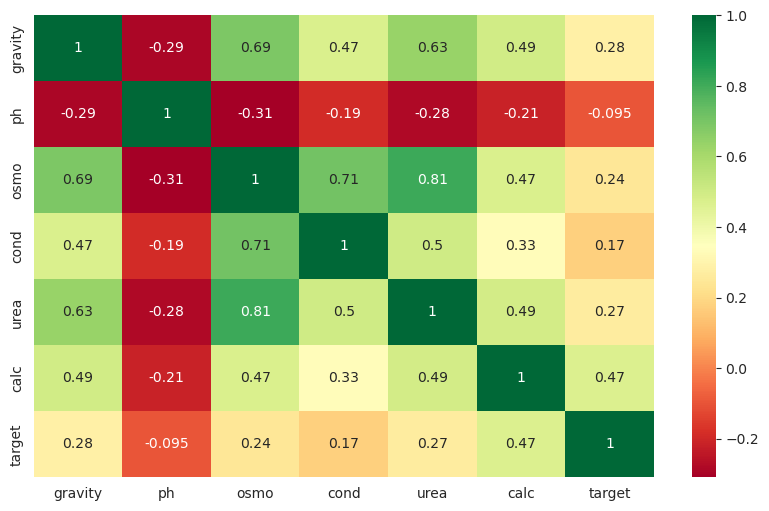

In [13]:
#Use Correlation matrix
correlation_matrix(df)

Here we can see that osmo - cond (0.71) and osmo - urea (0.81) are high correlated. So, we gonna remove feature osmo, because for both we can see that osmo are high correlated with cond and urea, while cond and urea are not high correlated. You can also remove urea and cond, but then u lose to much information.

<p style = "font-size: 16px; text-align:center;">So I am gonna remove osmo. </p>

In [14]:
df_logistic = df_logistic.drop(['osmo'], axis = 1) 
test_logistic = test_logistic.drop(['osmo'], axis = 1) 

The last step is the independece of errors. That is the errors (or residuals) between the predicted and actual values of the dependent variable should be independt for each other. This means that the value of the error for one obervation should not be related to the value of the error for another observation in the dataset. So we gonna  setup logistic model and than check the residual series.

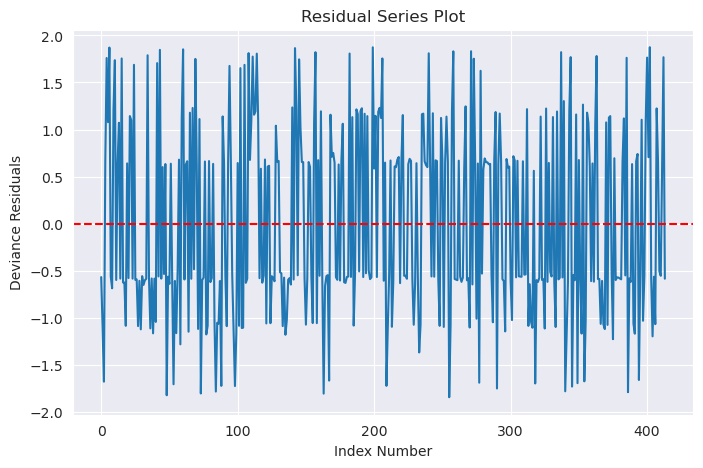

In [15]:
X = df.drop(['target'], axis = 1) 
y = df['target'] 

X_logistic = df_logistic.drop(['target'], axis = 1) 
y_logistic = df_logistic['target'] 
residuals(X_logistic, y_logistic)

<p style = "font-size: 16px; text-align:center;">Here we can see that the assumption is satisfied! </p>

For the next step we gonna run the machine learning model, but we already now we have one problem and that is overfitting. To detect overfitting we gonna use the hold-out validation. The dataset will be split into two parts: a training set and a validation set. The model is trained on the training set and evaluated on the validation set. If the model performs well on the training set but poorly on the validation.


In [16]:
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(X_logistic, y_logistic, test_size=0.2) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
LogReg = LogisticRegression()
LogReg.fit(X_train_logistic, y_train_logistic)
train_prediction = LogReg.predict(X_train_logistic)
validation_prediction = LogReg.predict(X_test_logistic)
print('ROC of logistic regression classifier on train set: {:.2f}'.format(roc_auc_score(y_train_logistic, train_prediction)))
print('ROC of logistic regression classifier on validation set: {:.2f}'.format(roc_auc_score(y_test_logistic, validation_prediction)))

ROC of logistic regression classifier on train set: 0.72
ROC of logistic regression classifier on validation set: 0.72


<p style = "font-size: 16px; text-align:center;">We can see that the train_set higher score has than validation set. <br> So this model may be overfitting. Now we gonna use regularization techniques, so they can penalize complex models and prevent overfitting.</p>

In [39]:
C = [0.01, 0.1, 1, 10, 100, 1000]

train_score = []
test_score = []

for i in C:
    model = LogisticRegression(max_iter = 500, penalty='l2',C = i)    
    model = model.fit(X_train_logistic, y_train_logistic) 
    
    y_pred_train = model.predict(X_train_logistic) 
    roc_auc_score_train = roc_auc_score(y_train_logistic, y_pred_train) 
    train_score.append(roc_auc_score_train) 
    
    y_pred_test = model.predict(X_test_logistic)
    roc_auc_score_validation = roc_auc_score(y_test_logistic, y_pred_test)
    test_score.append(roc_auc_score_validation)
    
    print('>%d, train: %.3f, test: %.3f' % (i, roc_auc_score_train, roc_auc_score_validation))


>0, train: 0.700, test: 0.609
>0, train: 0.737, test: 0.732
>1, train: 0.738, test: 0.732
>10, train: 0.741, test: 0.732
>100, train: 0.744, test: 0.732
>1000, train: 0.744, test: 0.732


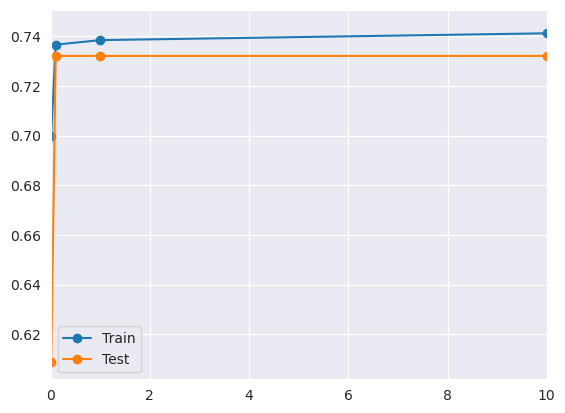

In [40]:
plt.plot(C, train_score, '-o', label='Train') 
plt.plot(C, test_score, '-o', label='Test') 
plt.legend()
plt.xlim(0,10)
plt.show() 

<p style = "font-size: 16px; text-align:center;">Here we can see that the C = 0.1 the best is! No overfitting and the best score for the test set. </p>


In [ ]:
LogReg = LogisticRegression(max_iter = 500, penalty='l2', C=0.1)
LogReg.fit(X_train_logistic, y_train_logistic)
Result = LogReg.predict(test_logistic) 
prediction = pd.DataFrame(Result, columns=['target'], index=submission_id).to_csv('submissionLogisticRegression.csv') #Put in the csv file!

<p style = "font-size: 16px; text-align:center;">Score: 0.7333 Place: 235 on 5 april 2023 </p>

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Model 2: Decision Tree</h1>
</div>

Decision Tree Regression have an advantage that it is easy to understand, lesser data cleaning is required, non-linearity does not affect the model's performance and the number of hyper-parameters to be tuned is almost null. However, it may have an over-fitting problem!

<p style = "font-size: 16px; text-align:center;">Overfitting is a common explanation for the poor performace of a predictive model. So we need to look out how depth our tree need to be!</p>

Let's tune the parameters with the decision tree. The most important parameters are: max-depth: This sets the maximum depth of the decision tree, min_samples_plit:  The minimum number of samples required to split an internal node. min_samples_leaf: The minimum number of samples required to be at a leaf node and the criterion: The function used to measure the quality of a split. The default is "gini", which uses the gini impurtiy measure. Alternative is the entropy for the information gain measure.

In [41]:
depths = [ i for i in range(1, 11)]
sample_split = [ i for i in range(2, 11)]
sample_leaf = [ i for i in range(2, 11)]


train_score = []
test_score = []
best_value = 0
best_depths = 0
best_split = 0
best_leaf = 0

for i in depths:
    for x in sample_split:
        for y in sample_leaf:
            model = DecisionTreeClassifier(criterion= "entropy", max_depth= i, min_samples_split= x, min_samples_leaf= y) 
            model = model.fit(X_train, y_train) 

            y_pred_train = model.predict(X_train) 
            roc_auc_score_train = roc_auc_score(y_train, y_pred_train) 
            train_score.append(roc_auc_score_train) 

            y_pred_test = model.predict(X_test)
            roc_auc_score_validation = roc_auc_score(y_test, y_pred_test)
            test_score.append(roc_auc_score_validation)
            
            if roc_auc_score_train > roc_auc_score_validation:
                None
            else:
                if roc_auc_score_validation >= best_value:
                    best_value = roc_auc_score_validation
                    best_depths = i
                    best_split = x
                    best_leaf = y
                else:
                    None   

print('The best tunig parameters are --> depth: %d, split: %d, leaf: %d with score: %.3f' % (best_depths, best_split, best_leaf, best_value))

The best tunig parameters are --> depth: 4, split: 10, leaf: 6 with score: 0.778


In [ ]:
DecisionTree = DecisionTreeClassifier(max_depth= best_depths, min_samples_split=best_split, min_samples_leaf=best_leaf) 
DecisionTree.fit(X_train, y_train) 
Result = DecisionTree.predict(test) 
Result
prediction = pd.DataFrame(Result, columns=['target'], index=submission_id).to_csv('submissionDecisionTree.csv') #Put in the csv file!

<p style = "font-size: 16px; text-align:center;">Score: 0.8133 Place: 191 on 5 april 2023 </p>

<div style = "background-color: beige; border-radius: 30px 20px;"> 
<h1 style = "text-align:center;">Model 3: Random Forest</h1>
</div>

In [42]:
depths = [ i for i in range(1, 11)]
sample_split = [ i for i in range(2, 11)]
sample_leaf = [ i for i in range(2, 11)]


train_score = []
test_score = []
best_value = 0
best_depths = 0
best_split = 0
best_leaf = 0

for i in depths:
    for x in sample_split:
        for y in sample_leaf:
            model = RandomForestClassifier(max_depth= i, min_samples_split= x, min_samples_leaf= y) 
            model = model.fit(X_train, y_train) 

            y_pred_train = model.predict(X_train) 
            roc_auc_score_train = roc_auc_score(y_train, y_pred_train) 
            train_score.append(roc_auc_score_train) 

            y_pred_test = model.predict(X_test)
            roc_auc_score_validation = roc_auc_score(y_test, y_pred_test)
            test_score.append(roc_auc_score_validation)
                       
            if roc_auc_score_train > roc_auc_score_validation:
                None
            else:
                if roc_auc_score_validation >= best_value:
                    best_value = roc_auc_score_validation
                    best_depths = i
                    best_split = x
                    best_leaf = y
                else:
                    None  

print('The best tunig parameters are --> depth: %d, split: %d, leaf: %d with score: %.3f' % (best_depths, best_split, best_leaf, best_value))

The best tunig parameters are --> depth: 7, split: 8, leaf: 9 with score: 0.813


In [ ]:
RandomForest = RandomForestClassifier(max_depth= best_depths, min_samples_split=best_split, min_samples_leaf=best_leaf) 
RandomForest.fit(X_train, y_train) 
Result = RandomForest.predict(test) 
prediction = pd.DataFrame(Result, columns=['target'], index=submission_id).to_csv('submission.csv') #Put in the csv file!

<p style = "font-size: 16px; text-align:center;">Score: 0.8333 Place: 237 on 6 april 2023 </p>

In [29]:
Knn = KNeighborsClassifier(n_neighbors=8, leaf_size=10)
Knn.fit(X_train, y_train)

y_pred_train = Knn.predict(X_train) 
roc_auc_score_train = roc_auc_score(y_train, y_pred_train) 
print(roc_auc_score_train)

y_pred_test = Knn.predict(X_test)
roc_auc_score_validation = roc_auc_score(y_test, y_pred_test)
print(roc_auc_score_validation)

0.6960773480662984
0.5573229291716687


In [19]:
n_neighbors = [ i for i in range(1, 50)]
leaf_size = [ i for i in range(2, 100)]

train_score = []
test_score = []
best_value = 0
best_n_neighbors = 0
best_leaf_size = 0

for i in n_neighbors:
    for x in leaf_size:
        model = KNeighborsClassifier(n_neighbors= i, leaf_size= x) 
        model = model.fit(X_train, y_train) 

        y_pred_train = model.predict(X_train) 
        roc_auc_score_train = roc_auc_score(y_train, y_pred_train) 
        train_score.append(roc_auc_score_train) 

        y_pred_test = model.predict(X_test)
        roc_auc_score_validation = roc_auc_score(y_test, y_pred_test)
        test_score.append(roc_auc_score_validation)

        if roc_auc_score_train > roc_auc_score_validation:
            None
        else:
            if roc_auc_score_validation >= best_value:
                best_value = roc_auc_score_validation
                best_n_neighbors = i
                best_leaf_size = x
            else:
                None  

print('The best tunig parameters are --> best_n_neighbors: %d, best_leaf_size: %d, with score: %.3f' % (best_n_neighbors, best_leaf_size, best_value))

The best tunig parameters are --> best_n_neighbors: 0, best_leaf_size: 0, with score: 0.000
